# Car Telemetry with Transformers

This notebook generates synthetic car telemetry and trains a small Transformer encoder to detect anomalies. The code walks through data preparation, model training and analysis of which features contribute most to an anomaly score.

## Data generation and model setup
The first code cell imports dependencies, selects the GPU if available and constructs a simple synthetic dataset of car telemetry. The numeric features are standardised and combined with learnable positional embeddings so that a Transformer encoder can model the time sequence.

Using device: cuda
Train input shape: torch.Size([80, 6])
First few rows:
 tensor([[ 0.8478, -2.1293, -1.0557,  1.3581,  1.9871,  1.1940],
        [ 1.5058, -3.0920, -2.1217, -1.0213, -1.1832,  0.3762],
        [-0.4915, -1.7551, -0.4025,  1.8778, -0.7865,  0.5398],
        [ 1.1566,  0.9015, -2.6467, -0.6007, -1.1218,  0.6809],
        [ 1.0384,  1.3531, -1.5226,  0.5421, -0.4131,  0.5299]],
       grad_fn=<ToCopyBackward0>)


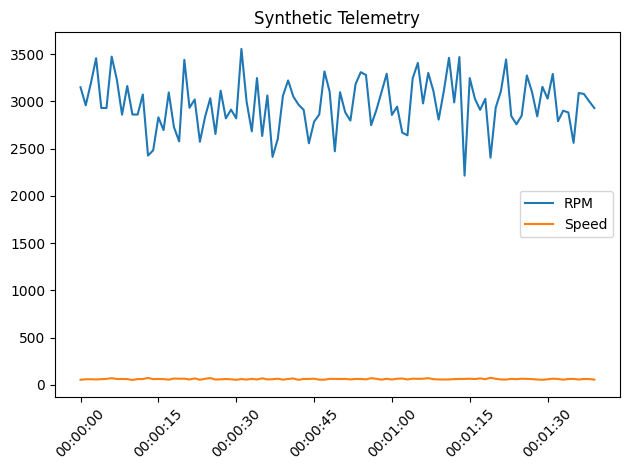

c:\Users\dev\Dropbox\ai_ml\.venv\Lib\site-packages\torch\nn\modules\transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


In [1]:
# ─────────────────────────────────────────────────────────────────────────────
# 1. Import Libraries
# ─────────────────────────────────────────────────────────────────────────────
import pandas as pd
import numpy as np
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

# ─────────────────────────────────────────────────────────────────────────────
# 2. Set Device
# ─────────────────────────────────────────────────────────────────────────────
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# ─────────────────────────────────────────────────────────────────────────────
# 3. Simulate Telemetry Data
# ─────────────────────────────────────────────────────────────────────────────
np.random.seed(42)
time_steps = 100

data = {
    "timestamp": pd.date_range("2025-01-01", periods=time_steps, freq="1s"),
    "rpm": np.random.normal(3000, 300, time_steps),
    "speed": np.random.normal(60, 5, time_steps),
    "gear": np.random.randint(1, 6, time_steps),
    "brake": np.random.choice([0, 1], time_steps, p=[0.9, 0.1]),
    "coolant_temp": np.random.normal(190, 5, time_steps),
    "throttle_pos": np.random.uniform(0, 100, time_steps)
}

df = pd.DataFrame(data)

# ─────────────────────────────────────────────────────────────────────────────
# 4. Normalize Features and Split
# ─────────────────────────────────────────────────────────────────────────────
features = ["rpm", "speed", "gear", "brake", "coolant_temp", "throttle_pos"]
normalized = (df[features] - df[features].mean()) / df[features].std()

split_idx = int(0.8 * len(normalized))
train_norm = normalized.iloc[:split_idx]
val_norm = normalized.iloc[split_idx:]

# ─────────────────────────────────────────────────────────────────────────────
# 5. Positional Encoding for Train/Val
# ─────────────────────────────────────────────────────────────────────────────
T, D = normalized.shape
position_embedding_layer = nn.Embedding(T, D).to(device)

train_pos_ids = torch.arange(len(train_norm)).unsqueeze(1).to(device)
val_pos_ids = torch.arange(len(val_norm)).unsqueeze(1).to(device)
train_pos_emb = position_embedding_layer(train_pos_ids.squeeze())
val_pos_emb = position_embedding_layer(val_pos_ids.squeeze())

# ─────────────────────────────────────────────────────────────────────────────
# 6. Prepare Tensors for Model
# ─────────────────────────────────────────────────────────────────────────────
train_tensor = torch.tensor(train_norm.values, dtype=torch.float32).to(device)
val_tensor = torch.tensor(val_norm.values, dtype=torch.float32).to(device)
train_input = train_tensor + train_pos_emb
val_input = val_tensor + val_pos_emb

# ─────────────────────────────────────────────────────────────────────────────
# 7. Visualize a Sample
# ─────────────────────────────────────────────────────────────────────────────
print("Train input shape:", train_input.shape)
print("First few rows:\n", train_input[:5].cpu())

plt.plot(df["timestamp"], df["rpm"], label="RPM")
plt.plot(df["timestamp"], df["speed"], label="Speed")
plt.legend()
plt.title("Synthetic Telemetry")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# ─────────────────────────────────────────────────────────────────────────────
# 8. Transformer Encoder Model
# ─────────────────────────────────────────────────────────────────────────────
class SimpleTransformerEncoder(nn.Module):
    def __init__(self, input_dim, nhead, num_layers, dim_feedforward):
        super().__init__()
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=input_dim, nhead=nhead, dim_feedforward=dim_feedforward
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.output_layer = nn.Linear(input_dim, input_dim)

    def forward(self, x):
        x = x.unsqueeze(1)  # (seq_len, 1, input_dim)
        x = self.transformer(x)
        x = x.squeeze(1)    # (seq_len, input_dim)
        return self.output_layer(x)

model = SimpleTransformerEncoder(
    input_dim=train_input.shape[1], nhead=2, num_layers=2, dim_feedforward=128
).to(device)



## Training loop
The second code cell trains the Transformer encoder to reconstruct its input. Mean squared error is used as the loss and both training and validation losses are plotted during training.

Epoch 1/100 - Train Loss: 2.4222 - Val Loss: 2.5066
Epoch 10/100 - Train Loss: 2.0614 - Val Loss: 2.1057
Epoch 20/100 - Train Loss: 1.8122 - Val Loss: 1.8627
Epoch 30/100 - Train Loss: 1.6837 - Val Loss: 1.7123
Epoch 40/100 - Train Loss: 1.5870 - Val Loss: 1.6079
Epoch 50/100 - Train Loss: 1.5205 - Val Loss: 1.5273
Epoch 60/100 - Train Loss: 1.4519 - Val Loss: 1.4515
Epoch 70/100 - Train Loss: 1.4294 - Val Loss: 1.3706
Epoch 80/100 - Train Loss: 1.3421 - Val Loss: 1.3043
Epoch 90/100 - Train Loss: 1.2812 - Val Loss: 1.2441
Epoch 100/100 - Train Loss: 1.2403 - Val Loss: 1.2051


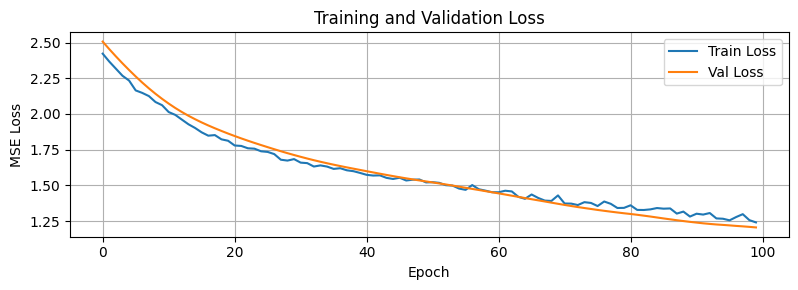

In [6]:
# ─────────────────────────────────────────────────────────────────────────────
# 9. Train the Transformer Encoder Model (with CUDA support)
# ─────────────────────────────────────────────────────────────────────────────

# Clear CUDA cache first
if torch.cuda.is_available():
    torch.cuda.empty_cache()

epochs = 100
learning_rate = 1e-3
criterion = nn.MSELoss()
model = SimpleTransformerEncoder(
    input_dim=train_input.shape[1], nhead=2, num_layers=2, dim_feedforward=128
).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Create fresh copies of input tensors to avoid graph issues
train_input_copy = train_input.clone().detach()
val_input_copy = val_input.clone().detach()

train_losses = []
val_losses = []
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    output = model(train_input_copy)
    loss = criterion(output, train_input_copy)
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())

    # Validation loss
    model.eval()
    with torch.no_grad():
        val_output = model(val_input_copy)
        val_loss = criterion(val_output, val_input_copy)
        val_losses.append(val_loss.item())

    if (epoch + 1) % 10 == 0 or epoch == 0:
        print(f"Epoch {epoch+1}/{epochs} - Train Loss: {loss.item():.4f} - Val Loss: {val_loss.item():.4f}")

plt.figure(figsize=(8, 3))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.title("Training and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.grid(True)
plt.tight_layout()
plt.legend()
plt.show()



## Scoring anomalies
After training, the model runs on the full sequence. The per time-step reconstruction error becomes the anomaly score, which is visualised to highlight unusual behaviour in the synthetic telemetry.

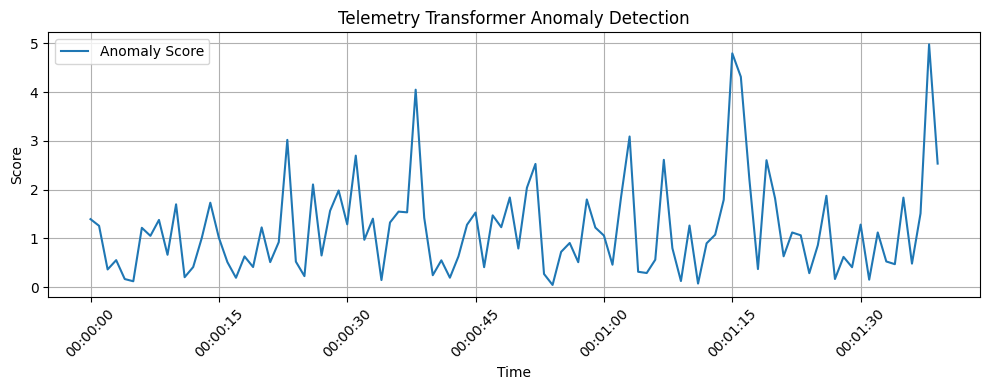

In [7]:
# ─────────────────────────────────────────────────────────────────────────────
# 10. Forward Pass and Anomaly Score Calculation (on all data)
# ─────────────────────────────────────────────────────────────────────────────
# Rebuild full positional embeddings for all data
position_ids = torch.arange(T).unsqueeze(1).to(device)
position_embeddings = position_embedding_layer(position_ids.squeeze())
inputs = torch.tensor(normalized.values, dtype=torch.float32).to(device)
transformer_input = inputs + position_embeddings

model.eval()
with torch.no_grad():
    reconstructed = model(transformer_input)

loss_per_timestep = F.mse_loss(reconstructed, transformer_input, reduction='none').mean(dim=1)
anomaly_scores = loss_per_timestep.detach().cpu().numpy()
df["anomaly_score"] = anomaly_scores

# ─────────────────────────────────────────────────────────────────────────────
# 11. Visualize Results
# ─────────────────────────────────────────────────────────────────────────────
plt.figure(figsize=(10, 4))
plt.plot(df["timestamp"], df["anomaly_score"], label="Anomaly Score")
plt.title("Telemetry Transformer Anomaly Detection")
plt.xlabel("Time")
plt.ylabel("Score")
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.legend()
plt.show()

## Analysing feature contributions
The final code cell looks at how each telemetry feature contributes to the anomaly score. Reconstruction errors are examined feature by feature and visualisations show which signals have the largest effect for the most anomalous points.

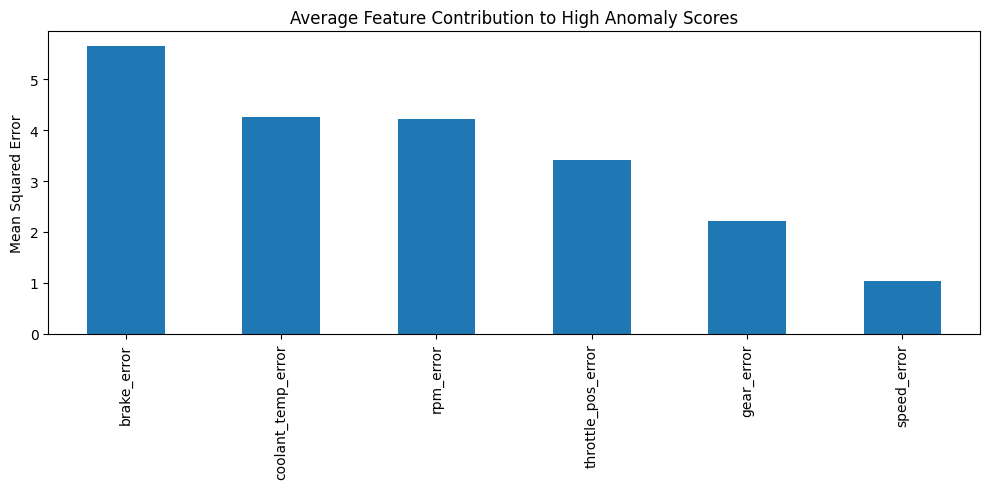

Top 3 anomaly points and their feature errors:
    rpm_error  speed_error  gear_error  brake_error  coolant_temp_error  \
98   1.317453     0.120112    3.086099    12.354466            9.167605   
75   5.314132     1.556362    5.200985    10.400938            0.033488   
76   2.204119     2.584758    5.154859    11.561751            2.510978   

    throttle_pos_error           timestamp  anomaly_score  
98            3.845574 2025-01-01 00:01:38       4.981885  
75            6.277926 2025-01-01 00:01:15       4.797306  
76            1.879258 2025-01-01 00:01:16       4.315954  


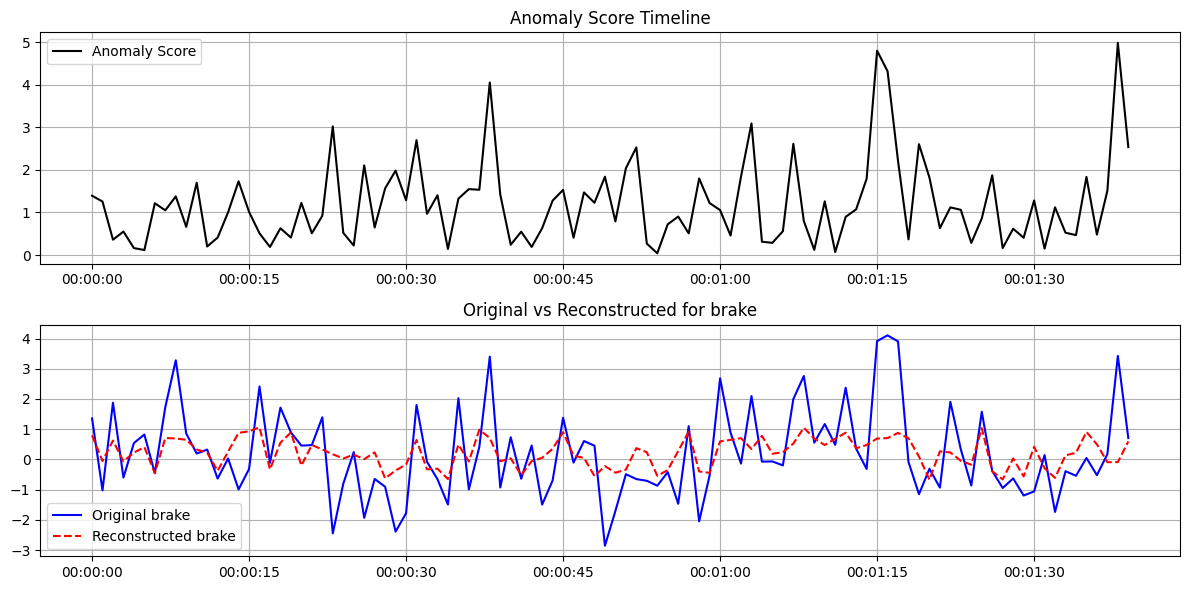

In [8]:
# ─────────────────────────────────────────────────────────────────────────────
# 12. Feature-Level Contribution Analysis
# ─────────────────────────────────────────────────────────────────────────────
# Calculate per-feature reconstruction errors
feature_errors = F.mse_loss(reconstructed, transformer_input, reduction='none').detach().cpu().numpy()

# Create DataFrame with per-feature errors
error_df = pd.DataFrame(feature_errors, columns=[f"{col}_error" for col in features])
error_df["timestamp"] = df["timestamp"]
error_df["anomaly_score"] = df["anomaly_score"]

# Find top anomaly points (e.g., top 10% of scores)
threshold = np.percentile(df["anomaly_score"], 90)
high_anomaly_points = error_df[error_df["anomaly_score"] > threshold]

# Calculate average contribution of each feature to high anomaly scores
feature_contribution = high_anomaly_points[[f"{col}_error" for col in features]].mean()
feature_contribution = feature_contribution.sort_values(ascending=False)

# Visualize feature contributions
plt.figure(figsize=(10, 5))
feature_contribution.plot(kind='bar')
plt.title("Average Feature Contribution to High Anomaly Scores")
plt.ylabel("Mean Squared Error")
plt.tight_layout()
plt.show()

# Visualize the features with highest contribution for top 3 anomalies
top_anomalies = error_df.nlargest(3, "anomaly_score")
print("Top 3 anomaly points and their feature errors:")
print(top_anomalies)

# Plot original vs. reconstructed for highest contributor feature
highest_contrib_feature = feature_contribution.index[0].replace("_error", "")
highest_idx = features.index(highest_contrib_feature)

plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(df["timestamp"], df["anomaly_score"], 'k-', label="Anomaly Score")
plt.title("Anomaly Score Timeline")
plt.grid(True)
plt.legend()

plt.subplot(2, 1, 2)
original = transformer_input.detach().cpu().numpy()[:, highest_idx]
reconstructed_np = reconstructed.detach().cpu().numpy()[:, highest_idx]
plt.plot(df["timestamp"], original, 'b-', label=f"Original {highest_contrib_feature}")
plt.plot(df["timestamp"], reconstructed_np, 'r--', label=f"Reconstructed {highest_contrib_feature}")
plt.title(f"Original vs Reconstructed for {highest_contrib_feature}")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()